# Presentation: NFL Exploration and Modelling

© MIT Kevin Patel

In [1]:
from IPython.display import display, Image
import pandas as pd
import numpy as np
from altair import *
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
work_dir = './data/kpatel28/'
using_year = '2016'
raw_file_path = work_dir + using_year + '-nfl-all.csv'
penalty_file_path = work_dir + using_year + '-nfl-penalties.csv'
other_file_path = work_dir + using_year + '-nfl-other.csv'
plays_file_path = work_dir + using_year + '-nfl-plays.csv'

## Abstract

Football is a complicated spectator sport, especially compared to other popular spectator sports such as basketball and soccer. Unlike many sports, football has large teams, highly differentiated team roles, and multiple ways to score. This work attempts to shed light on major league football play by examining a dataset of free play-by-play data from the 2016 NFL season. Owing to the complexity of the game, this work will focus primarily on plays and yardage as these have the most effect on game outcomes. Exploratory data analysis will answer questions about the game and season such as variables affecting passing and rushing plays. This work also includes two different classifiers - one for yardage and another for pass completions with two different implementations each that are discussed in depth. The first classifer (Binary Yardage) best implementation acheived an accuracy of 74%, precision of 85%, and recall of 67%. The second (Binary Pass Completion) best implementation acheived an F1 score of nearly 79%.

## Background

The aim of this project is to gain insights about the 2016 NFL season (and perhaps NFL football play in general) through the 2016 NFL regular and playoff play-by-play data produced by Dan Willman. Most of this project ignores events such as penalties, extra points, and two point conversions in favor of focusing on plays (passes, rushes, etc).

## Data Overview

The data used for this project was produced/compiled by Dan Willman of the NFLsavant.com website. This is the best free NFL data I was able to find. The data is in a tidy format where each observation is a game event such as a play or penalty call. Columns contain information such as the game date, event time in the game, yards gained (if any), and the location of the yardline. There are 36 columns/variables and over 45 thousand rows. The Description column is special in that it describes the event/play in a variable length string. This was probably some or most of the raw data that Willman's data was produced from.

Dan Willman makes this data available for every NFL regular and playoff season since 2013, but I will be using the 2016 dataset in this presentation.

In [3]:
raw = pd.read_csv(raw_file_path)
raw.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,...,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
0,2016090800,2016-09-08,1,0,0,NaN,CAR,0,0,0,...,0,0,NaN,0,OWN,0,NaN,0,NaN,0
1,2016090800,2016-09-08,4,2,0,NaN,CAR,0,0,0,...,0,0,NaN,0,OWN,0,NaN,0,NaN,0
2,2016091100,2016-09-11,4,6,18,NaN,TB,0,0,0,...,0,0,NaN,0,OWN,0,NaN,0,NaN,0
3,2016091100,2016-09-11,4,0,0,NaN,TB,0,0,0,...,0,0,NaN,0,OWN,0,NaN,0,NaN,0
4,2016091101,2016-09-11,2,0,0,NaN,BUF,0,0,0,...,0,0,NaN,0,OWN,0,NaN,0,NaN,0


## Data Preprocessing

I found that the most sane way of dealing with missing data was to separate the raw data into three subtables:

* 2016-NFL-plays.csv
* 2016-NFL-other.csv
* 2016-NFL-penalties.csv

Although all the rows are technically game events, they are all different types of observations that can't be compared in any interesting way. By separating the tables I found that most of the missing data was due to irrelevant variables (ie the value of PassType was missing during a Penalty call). Another reason I did this was because the NFL plays (ie passes, rushes, scrambles, etc) are the main focus of this project - especially the machine learning. 

There were a small amount of data imputations that were needed, but I was able to gain enough information from the Description column to do this (for instance this is where the DIRECT SNAP PlayType value comes from). Some very infrequent classes were also consolidated where possible.

## EDA Insights

Because this project was focused on plays and yardage, much of the EDA was examined passing and rushing. In this presentation, the focus will be on passing plays only as they provide the most yardage on average.

As you'd expect, the plays with the highest average yardage are passes, scrambles, and rushes. Consequently passing and rushing (in that order) are the two most common type of play.

In [4]:
file_path = work_dir + using_year + '-nfl-plays.csv'
plays = pd.read_csv(file_path)

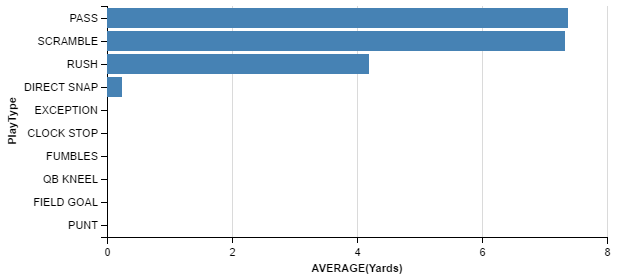

In [5]:
Chart(plays[plays['PlayType']!='SACK'][['PlayType', 'Yards']]).mark_bar().encode(
    x=X('average(Yards):Q'),
    y=Y('PlayType:N', sort=SortField(field='Yards', order='descending', op='mean')),
)

Most passes are short range to the left or right (the darker region represents the proportion of completed passes):

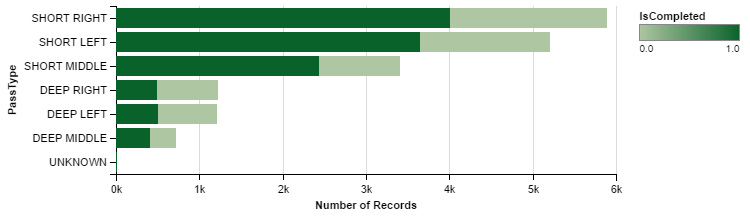

In [6]:
Chart(plays[plays['IsPass']==1][['PassType', 'IsCompleted']]).mark_bar().encode(
    x=X('count(*):Q'),
    y=Y('PassType:N', sort=SortField(field='PassType', order='descending', op='count')),
    color=Color('IsCompleted')
)

As expected, shorter passes have higher chances of completion. Interestingly passes to receivers in the middle region are more likely to be completed overall - with a significantly higher chance of success for longer distance passes:

In [7]:
plays[plays['IsPass']==1].groupby('PassType')[['IsCompleted', 'IsInterception', 'IsFumble', 'IsTouchdown', 'SeriesFirstDown', 'Yards']].mean()

,IsCompleted,IsInterception,IsFumble,IsTouchdown,SeriesFirstDown,Yards
PassType,,,,,,
DEEP LEFT,0.412541,0.047855,0.004125,0.067657,0.387789,11.093234
DEEP MIDDLE,0.571229,0.069832,0.008380,0.083799,0.526536,14.571229
DEEP RIGHT,0.406378,0.051513,0.004088,0.064595,0.381030,11.389207
SHORT LEFT,0.699022,0.011893,0.007865,0.036639,0.333014,6.252829
SHORT MIDDLE,0.715041,0.021445,0.010576,0.044653,0.408931,7.618096
SHORT RIGHT,0.680530,0.013410,0.008318,0.036836,0.317603,5.796639
UNKNOWN,0.437500,0.250000,0.125000,0.000000,0.062500,0.437500


Passes to the middle region on average:

* yield more yards
* are more likely to be completed (roughly 16% higher success rate for long distance case)
* are more associated with touchdowns
* are more associated with first downs

However, they are also more likely to lead to interception or fumbling.

Note - in shotgun the quarterback is snapped the ball from a distance, whereas in under center he is handed the ball in the snap. Most pass plays are done in the shotgun formation where the ball is snapped back in a toss, probably because the quarterback has more distance between him and the other team's defenders (the darker region represents the proportion of pass plays):

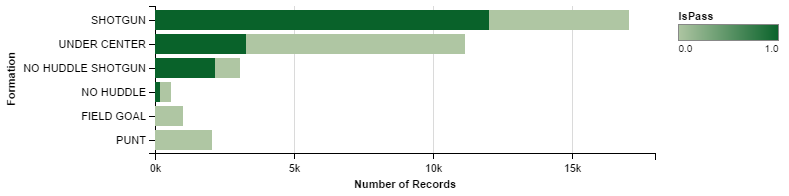

In [8]:
Chart(plays[['Formation', 'IsPass']]).mark_bar().encode(
    x=X('count(*):Q'),
    y=Y('Formation:N', sort=SortField(field='IsPass', order='descending', op='sum')),
    color=Color('IsPass'),
)

Suprisingly, the shotgun formation yields less yards on average than the under center formation, though the shotgun is far more common for passing plays:

In [9]:
plays[plays['IsPass']==1].groupby('Formation')[['IsCompleted', 'IsInterception', 'IsFumble', 'IsTouchdown', 'SeriesFirstDown', 'Yards']].mean()

,IsCompleted,IsInterception,IsFumble,IsTouchdown,SeriesFirstDown,Yards
Formation,,,,,,
FIELD GOAL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NO HUDDLE,0.736842,0.026316,0.000000,0.047368,0.494737,8.768421
NO HUDDLE SHOTGUN,0.638876,0.017043,0.008291,0.040534,0.372179,7.122064
SHOTGUN,0.649568,0.023695,0.008730,0.043648,0.345195,7.139092
UNDER CENTER,0.657534,0.018874,0.006393,0.048402,0.383257,8.369254


## Machine Learning

In order to prepare the data for machine learning, I first binned some of the numerical data which looked as though it could benefit from binning. There are no real-valued data so discretization wasn't necessary. I created binned versions of Second, ToGo, YardLine, YardLineFixed, and Yards. In the case of Yards, I also took the sign of the value as another data column. 

A final processing of the data was to convert string data to numerical encodings that could be used as features by scikit-learn models. Most of the columns were encoded with one-hot encoding to preven the encoding ordinality to be used in a learning model. This wasn't done in the case of OffenseTeam and DefenseTeam because that would have resulted in 62 columns alone - those variables were simply encoded from string to number code.

In [10]:
file_path = work_dir + using_year + '-nfl-plays_final.csv'
plays_final = pd.read_csv(file_path)

In [11]:
feats = plays_final[['GameMonth', 'Quarter', 'Minute', 'Second', 'BinnedSecond',
               'Down', 'ToGo', 'BinnedToGo', 'YardLine', 'BinnedYardLine',
               'YardLineFixed', 'BinnedYardLineFixed', 'IsPass', 'IsRush',
               'Enc_OffenseTeam', 'Enc_DefenseTeam',
               'YARDDIR_OWN',
               'FORM_NO HUDDLE', 'FORM_NO HUDDLE SHOTGUN', 'FORM_PUNT',
               'FORM_SHOTGUN', 'FORM_UNDER CENTER',
               'PLAY_DIRECT SNAP', 'PLAY_EXCEPTION', 'PLAY_FIELD GOAL', 'PLAY_FUMBLES', 'PLAY_PASS',
               'PLAY_PUNT', 'PLAY_QB KNEEL', 'PLAY_RUSH', 'PLAY_SACK', 'PLAY_SCRAMBLE',
               'PASS_DEEP MIDDLE', 'PASS_DEEP RIGHT', 'PASS_NOT APPLICABLE',
               'PASS_SHORT LEFT', 'PASS_SHORT MIDDLE', 'PASS_SHORT RIGHT', 'PASS_UNKNOWN',
               'RUSHDIR_LEFT END', 'RUSHDIR_LEFT GUARD', 'RUSHDIR_LEFT TACKLE',
               'RUSHDIR_NOT APPLICABLE', 'RUSHDIR_RIGHT END', 'RUSHDIR_RIGHT GUARD',
               'RUSHDIR_RIGHT TACKLE'
              ]]

The following is a simple function that takes a feature dataframe, label series, and scikit-learn interface classifier and returns the average accuracy, precision, recall, and feature importance (if available) over k folds:

In [12]:
def KFoldClassification(features, labels, clf, numTimes=5, imp=True):
    kf = KFold(n_splits=numTimes, shuffle=True)
    accuracy = np.zeros(kf.get_n_splits())
    precision = np.zeros(kf.get_n_splits())
    recall = np.zeros(kf.get_n_splits())
    importances = pd.DataFrame()
    i=0
    for train_idx, test_idx in kf.split(features):
        train_feats = features.iloc[train_idx]
        train_labels = labels.iloc[train_idx]
        clf.fit(train_feats, train_labels)

        test_feats = features.iloc[test_idx]
        test_labels = labels.iloc[test_idx]
        predictions = clf.predict(test_feats)
        accuracy[i] = accuracy_score(test_labels, predictions)
        precision[i] = precision_score(test_labels, predictions, labels=test_labels.unique(), average='macro')
        recall[i] = recall_score(test_labels, predictions, labels=test_labels.unique(), average='macro')
        i += 1
        if (imp):
            importances[i] = clf.feature_importances_

    stats = pd.DataFrame({'accuracy': accuracy.mean(), 'precision': precision.mean(), 'recall': recall.mean()}, index=[0])
    avg_importance_df = None
    if (imp):
        avg_importance = importances.mean(axis=1)
        avg_importance_df = pd.DataFrame({'feature':features.columns, 'avg_importance':avg_importance}).sort_values('avg_importance', ascending=False)
    return stats, avg_importance_df

### Precision and Recall

I decided to record precision and recall values alongside accuracy due to the imbalanced nature of some of my label classes. Precision and recall can give a more realistic view of performance than simple accuracy. Both are computed *per class* for each class of the label. In my case I averaged them if the classifer was not binary:

$Precision=\left(\frac{True Positives}{True Positives + False Positives}\right)$
, So the higher the precision, the lower the false positive rate (less observations are classified as the class in question that are not the class).

$Recall=\left(\frac{True Positives}{True Positives + False Negatives}\right)$
, So the higher the recall, the lower the miss rate (less observations from that class are missed).

There is usually a tradeoff between precision and recall.

### Sign Yardage Classifier

The first classifer I trained was designed to predict the sign of yardage in a play - either positive, negative, or no change. Without default tuning, the RandomForestClassifier model acheived:

* accuracy of about 70%
* precision of about 72%
* recall of about 58%

When the model is tuned accuracy increases a little, but precision rises to almost 90% (recall stays about the same):

In [13]:
labs = plays_final['SignYards']
stat, feat_imps = KFoldClassification(feats, labs, RandomForestClassifier(n_estimators=100, max_depth=5), imp=True)
print(stat)
feat_imps.iloc[:5]

   accuracy  precision   recall
0  0.739345   0.880873  0.57393


,avg_importance,feature
5,0.139665,Down
13,0.130211,IsRush
30,0.108763,PLAY_SACK
27,0.088706,PLAY_PUNT
29,0.079362,PLAY_RUSH


* accuracy of about 73% (3% increase)
* precision of about 88% (16% increase)
* recall of about 57% (1% decrease)

As poor as the results seem to be, it still provides an edge over guessing the most common class:

In [14]:
labs.value_counts(normalize=True)

 1    0.604718
 0    0.322193
-1    0.073089
Name: SignYards, dtype: float64

### Binary Yardage Classifier

I found that combining the negative (-1) and no yardage change (0) classes increased recall significantly (as would be expected), with a relatively small decrease in precision. Of course, it now predicts a different outcome. In this case it tells us whether a play was 'good' or not - did it result in positive yardage?

In [15]:
best_feats = ['Down', 'IsRush', 'PLAY_PUNT', 'IsPass', 'PLAY_RUSH', 'FORM_PUNT', 'PLAY_PASS']
labs = plays_final['SignYards'].map(lambda x: 0 if x == -1 else x) #Treat losses and no yardage as the same
stat, imps = KFoldClassification(feats[best_feats], labs, RandomForestClassifier(n_estimators=100, max_depth=6))
print(stat)
imps

   accuracy  precision   recall
0  0.740721   0.849763  0.67204


,avg_importance,feature
1,0.282019,IsRush
0,0.204825,Down
3,0.127355,IsPass
6,0.125287,PLAY_PASS
4,0.117375,PLAY_RUSH
2,0.079765,PLAY_PUNT
5,0.063373,FORM_PUNT


* accuracy of about 74% (1% increase)
* precision of about 85% (3% decrease)
* recall of about 67% (10% increase)

Once again, the model can be said to be better than the baseline of choosing the most common class:

In [16]:
labs.value_counts(normalize=True)

1    0.604718
0    0.395282
Name: SignYards, dtype: float64

Plotting the performance metrics of the classifer over the number of features used (sorted by importance), we see that only the first 5-10 features provide value to the model. A significant increase in recall (and accuracy) would probably require more orthogonal features or a more sophisticated model:

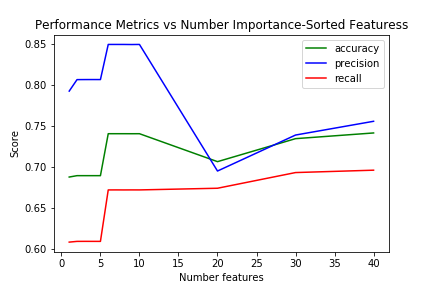

In [17]:
img = Image(filename='./figures/YardClassifierPerformanceVsFeatures.png', embed=True, width=500, height=500)
display(img)

I had also attempted to use the AdaBoost algorithm (with a base decision tree estimator) to increase the fitting of the model, but no hyperparameter tuning could yield a better performing model.

### Binary Pass Completion Classifier

Now let's look at factors that can help predict a completed pass. First we need to remove the rows that are not pass plays and columns (features) that are irrlevant or will cause the model to cheat:

In [18]:
feats_pass = plays_final[plays_final['IsPass']==1][['GameMonth', 'Quarter', 'Minute', 'Second', 'BinnedSecond',
               'Down', 'ToGo', 'BinnedToGo', 'YardLine', 'BinnedYardLine',
               'YardLineFixed', 'BinnedYardLineFixed',
               'Enc_OffenseTeam', 'Enc_DefenseTeam',
               'YARDDIR_OWN',
               'FORM_NO HUDDLE', 'FORM_NO HUDDLE SHOTGUN', 'FORM_PUNT',
               'FORM_SHOTGUN', 'FORM_UNDER CENTER',
               'PASS_DEEP MIDDLE', 'PASS_DEEP RIGHT', 'PASS_NOT APPLICABLE',
               'PASS_SHORT LEFT', 'PASS_SHORT MIDDLE', 'PASS_SHORT RIGHT', 'PASS_UNKNOWN',
              ]]
labs_pass = plays_final[plays_final['IsPass']==1]['IsCompleted']

In [19]:
stat, feat_imps = KFoldClassification(feats_pass, labs_pass, RandomForestClassifier(n_estimators=200, max_depth=7), imp=True)
print(stat)
p = stat['precision'].iloc[0]
r = stat['recall'].iloc[0]
print('F1:', 2*float((p*r) / (p+r)))
feat_imps[:5]

   accuracy  precision    recall
0  0.663649   0.631457  0.537407
F1: 0.5806479633275338


,avg_importance,feature
21,0.169308,PASS_DEEP RIGHT
8,0.084127,YardLine
23,0.062577,PASS_SHORT LEFT
3,0.061499,Second
13,0.058954,Enc_DefenseTeam


Unfortunately it looks like no amount of parameter tuning is able to get any of the metrics beyond the mid 60% with RandomForest.

### SVM Binary Pass Completion Classifier

https://en.wikipedia.org/wiki/Support_vector_machine

The support vector machine is one of the most powerful models in statistical machine learning. The main trouble behind it is that its hyper parameters are more difficult to tune to produce a useful model. For this project I had used an exhaustive grid search to tune the two most important parameters of this model - C and gamma (assuming an rbf kernel):

model.best_estimator_: SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
  
model.best_score_: 0.788346186545

model.best_params_: {'C': 0.001, 'gamma': 0.001}

Note that the score that was optimized was not accuracy, precision, or recall - but a statistic called the F1 score, the hamonic mean of the precision and recall. Usually:

$F1=2*\left(\frac{precision * recall}{precision + recall}\right)$

By optimizing for this value we are attempting to get a good tradeoff between precision and recall. Accordingly, we gain an F1 value of 78.8% - that is 21% beter than the F1 of the random forest model!

Both models are better than the baseline strategy of random guessing:

In [20]:
labs_pass.value_counts(normalize=True)

1    0.650636
0    0.349364
Name: IsCompleted, dtype: float64